# A Model for Rankings

$r_u(t)$ = the ranking of university $u$ at time $t$.

We'll use $t$ to represent time, which will generally think of
as discrete. Thus $r_u(t-1)$ is university $u$'s ranking the year before.

Let $M$ be the number of attributes in the ranking.

$y_{i,u}(t)$ = the value of university $u$'s i-th attribute,
where $i$ ranges from 1 to $M$.

$w_i(t)$ is the weightage given to attribute $i$ in the ranking.
This generally does not change frequently.

We will now define the _score_ of a university as

$$
     \mu_u(t) = \sum_{i} w_i(t) V_i(y_{i,u}(t))
$$


In [1]:
%matplotlib inline
from ranking_system import *
import matplotlib.pyplot as plt

total_number_of_time_steps = 10
total_number_of_universities = 2

# Attribute name and weight given to attribute in the ranking
attributes = [Attribute('research', 0.7), Attribute('faculty', 0.3)]

model = RankingModel(total_number_of_universities, attributes)

# Manually step though the time steps
for step in range(total_number_of_time_steps):
    model.step()


model.data_collector.get_agent_vars_dataframe()   


Score Unique ID
Step AgentID                      
0    agent-0   57.649669   agent-0
     agent-1   64.566973   agent-1
1    agent-0   59.523381   agent-0
     agent-1   72.351599   agent-1
2    agent-0   95.997571   agent-0
     agent-1   82.322154   agent-1
3    agent-0  113.735989   agent-0
     agent-1  100.847729   agent-1
4    agent-0  121.651620   agent-0
     agent-1  102.870435   agent-1
5    agent-0  123.720892   agent-0
     agent-1  108.010174   agent-1
6    agent-0  126.462230   agent-0
     agent-1  110.430652   agent-1
7    agent-0  129.804466   agent-0
     agent-1  112.277553   agent-1
8    agent-0  143.537192   agent-0
     agent-1  164.399638   agent-1
9    agent-0  145.975708   agent-0
     agent-1  177.268225   agent-1
10   agent-0  152.103304   agent-0
     agent-1  201.697325   agent-1

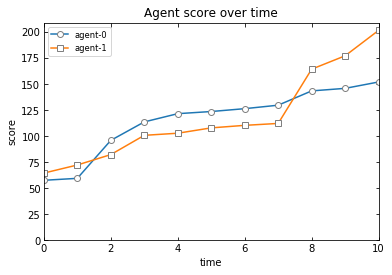

In [2]:
# Plot the agent score over time
dictionary_line_plot(plt, get_score_by_agent(model), 'time',
                     'score',
                     'Agent score over time', 0,
                     total_number_of_time_steps)